# 다빈 kaggle 자유분석

#### kick point

- 클래스 불균형 처리
    - `BorderlineSMOTE`
- 이진분류
    - `RandomForestClassifier`, `KNeighborsClassifier`,  `XGBClassifier`

---

### SUMMARY

1. [import](#1)
2. [Read the Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Feature Engineering](#4)
5. [Binary Classification](#5)

---

## 1. import
<a id="1"></a>

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from collections import Counter

## 2. Read the Data
<a id="2"></a>

In [60]:
df = pd.read_csv('../../data/캐글_파산기업/data.csv')

df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## 3. EDA
<a id="3"></a>

#### 3.1 데이터의 기본 정보 확인

In [61]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    #print("##################### Head #####################")
    #print(dataframe.head(3))
    #print("##################### Tail #####################")
    #print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
check_df(df)

##################### Shape #####################
(6819, 96)
##################### Types #####################
Bankrupt?                                                     int64
 ROA(C) before interest and depreciation before interest    float64
 ROA(A) before interest and % after tax                     float64
 ROA(B) before interest and depreciation after tax          float64
 Operating Gross Margin                                     float64
                                                             ...   
 Liability to Equity                                        float64
 Degree of Financial Leverage (DFL)                         float64
 Interest Coverage Ratio (Interest expense to EBIT)         float64
 Net Income Flag                                              int64
 Equity to Liability                                        float64
Length: 96, dtype: object
##################### NA #####################
Bankrupt?                                                   0
 ROA(C

#### 3.2 타겟변수 비율 확인

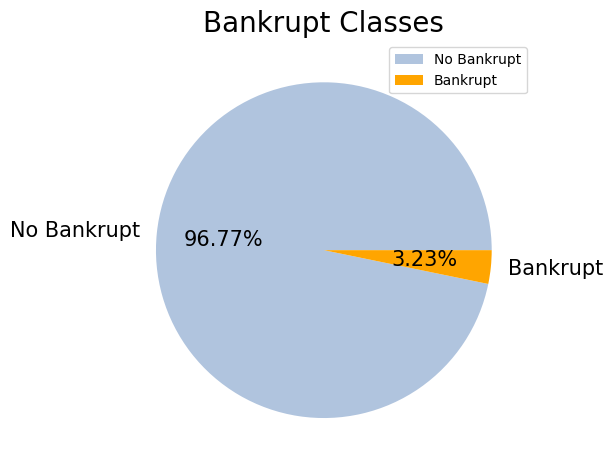

In [62]:
val = df['Bankrupt?'].value_counts().reset_index(name='count')

def label_function(val):
    return f'{val:.2f}%'

labels = ['No Bankrupt','Bankrupt']

val.plot(x='Bankrupt?',y='count',kind='pie',autopct=label_function,
                textprops={'fontsize':15},labels=labels,colors=['lightsteelblue','orange'])

plt.ylabel('')
plt.title('Bankrupt Classes',fontsize=20)

plt.tight_layout()

#### 3.3 df 내 각 열의 이상치 비율 확인

In [63]:
# 이상치 탐지 함수
def outlier_thresholds(dataframe, variable, low_quantile=0.15, up_quantile=0.85):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# 각 열의 이상치 비율을 계산하는 함수
def calculate_outlier_ratios(dataframe, low_quantile=0.15, up_quantile=0.85):
    outlier_ratios = {}
    
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):  # 숫자형 데이터만 처리
            low_limit, up_limit = outlier_thresholds(dataframe, column, low_quantile, up_quantile)
            # 이상치 조건
            outliers = dataframe[(dataframe[column] < low_limit) | (dataframe[column] > up_limit)]
            # 이상치 비율 계산
            outlier_ratio = len(outliers) / len(dataframe) * 100  # 비율을 백분율로 변환
            outlier_ratios[column] = outlier_ratio
            
    return outlier_ratios

outlier_ratios = calculate_outlier_ratios(df)
outlier_ratios

{'Bankrupt?': 3.2262795131250916,
 ' ROA(C) before interest and depreciation before interest': 1.0705382020824168,
 ' ROA(A) before interest and % after tax': 1.5984748496847045,
 ' ROA(B) before interest and depreciation after tax': 1.2465170846165128,
 ' Operating Gross Margin': 1.6864642909517522,
 ' Realized Sales Gross Margin': 1.6864642909517522,
 ' Operating Profit Rate': 3.519577650681918,
 ' Pre-tax net Interest Rate': 4.443466783985921,
 ' After-tax net Interest Rate': 4.86874908344332,
 ' Non-industry income and expenditure/revenue': 6.936500953218946,
 ' Continuous interest rate (after tax)': 4.648775480275701,
 ' Operating Expense Rate': 0.0,
 ' Research and development expense rate': 0.0,
 ' Cash flow rate': 2.639683238011439,
 ' Interest-bearing debt interest rate': 4.692770200909225,
 ' Tax rate (A)': 1.1145329227159408,
 ' Net Value Per Share (B)': 2.2730605660654053,
 ' Net Value Per Share (A)': 2.287725472943247,
 ' Net Value Per Share (C)': 2.287725472943247,
 ' Per

## 4. Feature Engineering
<a id="4"></a>

RandomForest를 사용하기 때문에 scaling을 진행하지 않았다.

In [64]:
print("데이터의 고유한 값이 1개인 열 : ", df.columns[df.nunique() == 1][0])
df.drop(df.columns[df.nunique() == 1][0],axis=1,inplace=True) 

데이터의 고유한 값이 1개인 열 :   Net Income Flag


In [65]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

#### 4.1 Resampling
이전 kaggle 연습코드에서 `BorderlineSMOTE`를 사용하였을 때 가장 좋은 성능을 보인 것 같아 동일한 sampling기법을 사용.

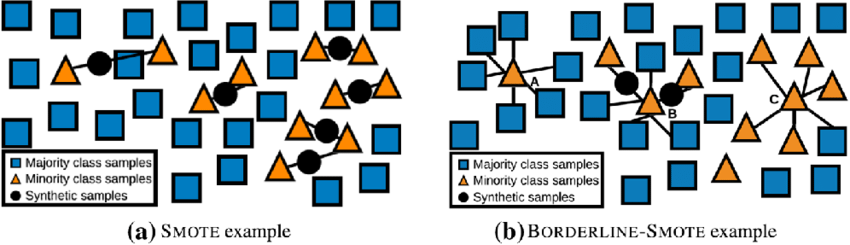

우선 minority class의 데이터 중 임의로 하나를 선택하고 그 데이터에서 가장 가까운 majority의 개수가 k 개라면 처음에 선택한 임의의 한 점은 noise, <br>
k개의 절반 이상이 majority라면 border point, 절반 미만이라면 safe 데이터로 분류한다. 

즉, 이 의미는 majority 가운데 minority가 있는지를 판별하는 것이다. 

noise, border, safe로 분류한 데이터 중에서 noise는 이미 분류하기 어려운 소수 데이터이므로 제외하고, safe는 이미 소수 데이터 끼리 잘 묶여있으므로 처리해줘야할 데이터는 border 뿐이다. 

​
따라서 border point에 해당하는 데이터만 SMOTE를 진행해준다. 

In [66]:
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 6599, 0: 6599})


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [68]:
len(X_train), len(X_test)

(10558, 2640)

## 5. Binary Classification
<a id="4"></a>

### 5.1 RandomForest

In [69]:
def get_test_scores(model_name: str, preds, y_true):
    '''
    Generate a table of test scores.

    In:
        model_name (string): 모델의 이름
        preds: 예측값 배열
        y_true: 실제 라벨 값 (numpy 배열)

    Out:
        table: pandas DataFrame 형태로 precision, recall, f1, accuracy 값을 반환
    '''
    accuracy  = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds, average='macro')
    recall    = recall_score(y_true, preds, average='macro')
    f1        = f1_score(y_true, preds, average='macro')

    table = pd.DataFrame({'model': [model_name], 'precision': [precision], 'recall': [recall],
                          'F1': [f1], 'accuracy': [accuracy]})

    return table 

- train data의 모형을 적합시키고, train data의 점수를 계산

In [70]:
random_forest = RandomForestClassifier(class_weight='balanced')

random_forest.fit(X_train,y_train)

# Use the model to predict on train data
rf_train_preds = random_forest.predict(X_train)

rf_train_results = get_test_scores('RF (train, borderlinesmote)',rf_train_preds,y_train)
rf_train_results

,model,precision,recall,F1,accuracy
0,"RF (train, borderlinesmote)",1.0,1.0,1.0,1.0


- 그런 다음 test data의 점수를 계산

In [71]:
# Use the model to predict on test data
rf_test_preds = random_forest.predict(X_test)

rf_test_results = get_test_scores('RF (test, borderlinesmote)',rf_test_preds,y_test)
rf_test_results

,model,precision,recall,F1,accuracy
0,"RF (test, borderlinesmote)",0.985677,0.985606,0.985606,0.985606


- GridSearchCV 수행

In [72]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [2,3,4,5,None],'max_features': [1.0],'max_samples': [1.0],
             'min_samples_leaf': [2,3,4],'min_samples_split': [2,3,4],'n_estimators': [200,300,400]}

# 3. Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf,cv_params,scoring=scoring,cv=4,refit='accuracy')

In [73]:
%%time
rf_cv.fit(X_train,y_train)

KeyboardInterrupt: 

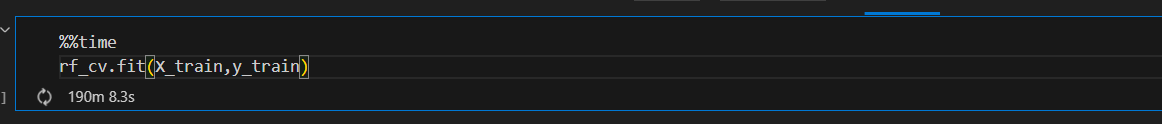

190분 오바

In [16]:
# Use the model to predict on test data
#rf_grid_test_preds = rf_cv.best_estimator_.predict(X_test)

#rf_grid_test_over_results = get_test_scores('RF Grid (test, borderlinesmote)',rf_grid_test_preds,y_test)

#rf_grid_test_over_results 

- 변수중요도

In [17]:
# Random Forest Model
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False) 

importances
importances[importances['importance'] > 0.02]

,feature,importance
39,Borrowing dependency,0.062
18,Persistent EPS in the Last Four Seasons,0.058
9,Continuous interest rate (after tax),0.052
67,Retained Earnings to Total Assets,0.048
37,Net worth/Assets,0.046
35,Total debt/Total net worth,0.042
42,Net profit before tax/Paid-in capital,0.039
85,Net Income to Total Assets,0.036
2,ROA(B) before interest and depreciation after...,0.030
7,After-tax net Interest Rate,0.030


- confusion matrix

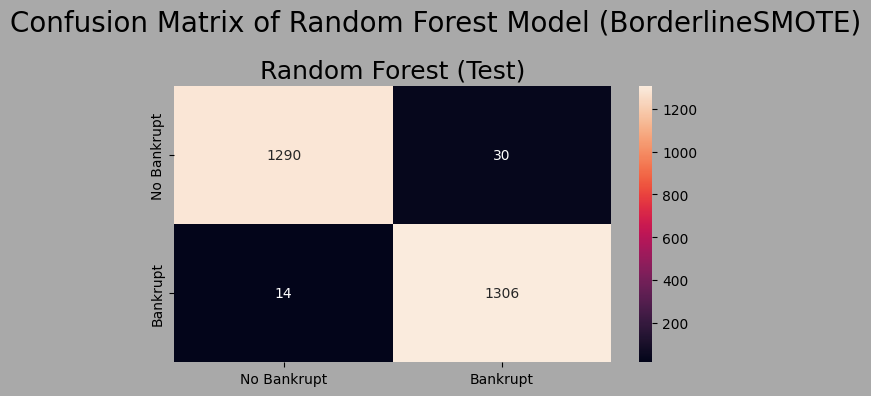

In [18]:
cm_rf_test = confusion_matrix(y_test, rf_test_preds, labels=random_forest.classes_)

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1 = sns.heatmap(cm_rf_test, annot=True, fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.set_title('Random Forest (Test)', fontsize=18)

fig.suptitle("Confusion Matrix of Random Forest Model (BorderlineSMOTE)", fontsize=20) 

plt.tight_layout()
fig.set_facecolor('darkgrey')
plt.show()

### 5.2. K Nearest Neighbours

- train data의 모형을 적합시키고, train data의 점수를 계산

In [19]:
KNN = KNeighborsClassifier(n_neighbors=2)

KNN.fit(X_train,y_train)

# Use the model to predict on train data
KNN_train_preds = KNN.predict(X_train)

KNN_train_results = get_test_scores('KNN (train, borderlinesmote)',KNN_train_preds,y_train)
KNN_train_results

,model,precision,recall,F1,accuracy
0,"KNN (train, borderlinesmote)",0.995681,0.995643,0.995643,0.995643


- 그런 다음 test data의 점수를 계산

In [20]:
# Use the model to predict on test data
KNN_test_preds = KNN.predict(X_test)

KNN_test_results = get_test_scores('KNN (test, borderlinesmote)',KNN_test_preds,y_test)
KNN_test_results

,model,precision,recall,F1,accuracy
0,"KNN (test, borderlinesmote)",0.96259,0.962121,0.962112,0.962121


- confusion matrix

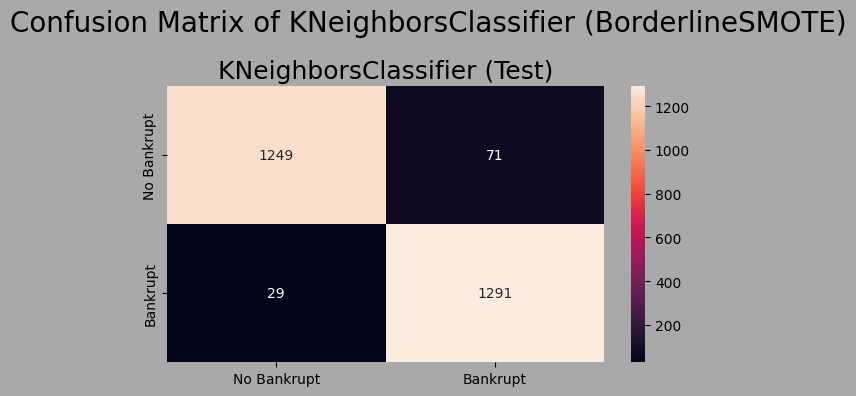

In [21]:
cm_KNN_test = confusion_matrix(y_test, KNN_test_preds, labels=KNN.classes_)

 
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1 = sns.heatmap(cm_KNN_test, annot=True, fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.set_title('KNeighborsClassifier (Test)', fontsize=18)

fig.suptitle("Confusion Matrix of KNeighborsClassifier (BorderlineSMOTE)", fontsize=20) 

plt.tight_layout()
fig.set_facecolor('darkgrey')
plt.show()

### 5.3 XGBoost

- train data의 모형을 적합시키고, train data의 점수를 계산

In [22]:
xgb = XGBClassifier(objective='binary:logistic',random_state=42)

xgb.fit(X_train,y_train)

# Use the model to predict on train data
xgb_train_preds = xgb.predict(X_train)

xgb_train_results = get_test_scores('XGB (train, borderlinesmote)',xgb_train_preds,y_train)
xgb_train_results

,model,precision,recall,F1,accuracy
0,"XGB (train, borderlinesmote)",1.0,1.0,1.0,1.0


- 그런 다음 test data의 점수를 계산

In [23]:
# Use the model to predict on test data
xgb_test_preds = xgb.predict(X_test)

xgb_test_results = get_test_scores('XGB (test, borderlinesmote)',xgb_test_preds,y_test)
xgb_test_results

,model,precision,recall,F1,accuracy
0,"XGB (test, borderlinesmote)",0.986108,0.985985,0.985984,0.985985


- confusion matrix

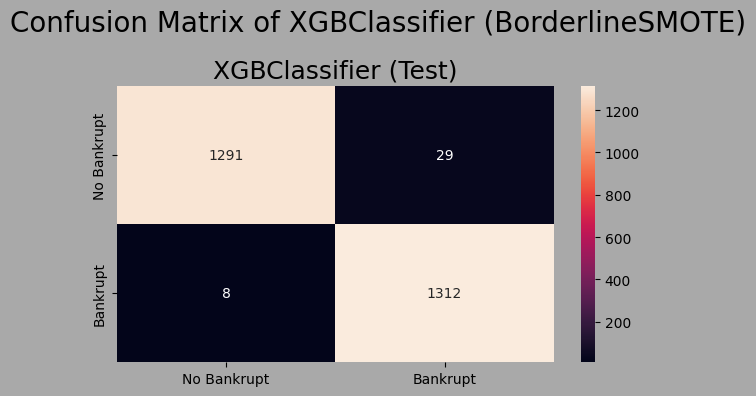

In [24]:
cm_xgb_test = confusion_matrix(y_test, xgb_test_preds, labels=xgb.classes_)

 
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1 = sns.heatmap(cm_xgb_test, annot=True, fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.set_title('XGBClassifier (Test)', fontsize=18)

fig.suptitle("Confusion Matrix of XGBClassifier (BorderlineSMOTE)", fontsize=20) 

plt.tight_layout()
fig.set_facecolor('darkgrey')
plt.show()

BorderlineSMOTE를 사용했을 때 전처리를 진행하지 않아도 전반적으로 성능이 좋게 나온다

In [25]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=42)

LR.fit(X_train,y_train)

# Use the model to predict on train data
LR_train_preds = LR.predict(X_train)

LR_train_results = get_test_scores('LR (train, borderlinesmote)',LR_train_preds,y_train)
LR_train_results

c:\Users\ldb76\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,precision,recall,F1,accuracy
0,"LR (train, borderlinesmote)",0.685514,0.680716,0.678638,0.680716


In [26]:
# Use the model to predict on test data
LR_test_preds = LR.predict(X_test)

LR_test_results = get_test_scores('LR (test, borderlinesmote)',LR_test_preds,y_test)
LR_test_results   

,model,precision,recall,F1,accuracy
0,"LR (test, borderlinesmote)",0.687641,0.683333,0.681505,0.683333


In [27]:
results = pd.concat([rf_test_results,KNN_test_results,xgb_test_results, LR_test_results],axis=0)

results.sort_values(by=['accuracy'],ascending=False)

,model,precision,recall,F1,accuracy
0,"XGB (test, borderlinesmote)",0.986108,0.985985,0.985984,0.985985
0,"RF (test, borderlinesmote)",0.983404,0.983333,0.983333,0.983333
0,"KNN (test, borderlinesmote)",0.962590,0.962121,0.962112,0.962121
0,"LR (test, borderlinesmote)",0.687641,0.683333,0.681505,0.683333


## 이상치 제거

In [28]:
# Function for outliers capping
def outlier_imputer(data,features):
    
    data_out = data.copy()
    
    for column in features:        
        
        # First define the first and third quartiles
        Q1 = data_out[column].quantile(0.25)
        Q3 = data_out[column].quantile(0.75)
        # Define the inter-quartile range
        IQR = Q3 - Q1
        # ... and the lower/higher threshold values
        lowerL = (Q1 - 1.5 * IQR)
        higherL = (Q3 + 1.5 * IQR)
        
        # 각 열에서 하한을 벗어난 값은 하한으로, 상한을 벗어난 값은 상한으로 대체
        # Impute 'left' outliers
        data_out.loc[data_out[column] < lowerL,column] = lowerL
        # Impute 'right' outliers
        data_out.loc[data_out[column] > higherL,column] = higherL
        
    return data_out 

# Outliers capping is carried out on the float columns only
df_in     = df.select_dtypes(include='float')
features_in = df_in.columns

capped_data = outlier_imputer(df_in,features_in)  

In [29]:
capped_data

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
0,0.387973,0.455122,0.442034,0.601457,0.601457,0.998969,0.797096,0.809075,0.303288,0.781314,...,0.068886,0.752193,0.009219,0.622879,0.601453,0.836752,0.288207,0.026608,0.564309,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.027096,0.566574,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.797096,0.809075,0.303288,0.781314,...,0.025346,0.774670,0.011819,0.623841,0.601449,0.836774,0.288207,0.026608,0.564309,0.016474
3,0.399844,0.455122,0.457733,0.583541,0.583541,0.998781,0.797096,0.809075,0.303350,0.781314,...,0.067250,0.752193,0.003252,0.622929,0.583538,0.836752,0.281721,0.026697,0.564663,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.047725,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.026608,0.566574,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0.027951,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,0.029890
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0.031470,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,0.038284
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0.007542,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,0.095380
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0.022916,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,0.044009


In [30]:
# 캡션된 데이터 세트에 정수형 열이 연결됩니다
df_int = df.select_dtypes(include='int')

df2 = pd.concat([capped_data,df_int],axis=1)

df2.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,Bankrupt?,Liability-Assets Flag
0,0.387973,0.455122,0.442034,0.601457,0.601457,0.998969,0.797096,0.809075,0.303288,0.781314,...,0.009219,0.622879,0.601453,0.836752,0.288207,0.026608,0.564309,0.016469,1,0
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.008323,0.623652,0.610237,0.839969,0.283846,0.027096,0.566574,0.020794,1,0
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.797096,0.809075,0.303288,0.781314,...,0.011819,0.623841,0.601449,0.836774,0.288207,0.026608,0.564309,0.016474,1,0
3,0.399844,0.455122,0.457733,0.583541,0.583541,0.998781,0.797096,0.809075,0.303350,0.781314,...,0.003252,0.622929,0.583538,0.836752,0.281721,0.026697,0.564663,0.023982,1,0
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.003878,0.623521,0.598782,0.839973,0.278514,0.026608,0.566574,0.035490,1,0


In [31]:
X = df2.drop('Bankrupt?',axis=1)
y = df2['Bankrupt?']

In [32]:
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 6599, 0: 6599})


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [34]:
len(X_train), len(X_test)

(10558, 2640)

### 5.1 RandomForest

In [35]:
def get_test_scores(model_name: str, preds, y_true):
    '''
    Generate a table of test scores.

    In:
        model_name (string): 모델의 이름
        preds: 예측값 배열
        y_true: 실제 라벨 값 (numpy 배열)

    Out:
        table: pandas DataFrame 형태로 precision, recall, f1, accuracy 값을 반환
    '''
    accuracy  = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds, average='macro')
    recall    = recall_score(y_true, preds, average='macro')
    f1        = f1_score(y_true, preds, average='macro')

    table = pd.DataFrame({'model': [model_name], 'precision': [precision], 'recall': [recall],
                          'F1': [f1], 'accuracy': [accuracy]})

    return table 

- train data의 모형을 적합시키고, train data의 점수를 계산

In [36]:
random_forest = RandomForestClassifier(class_weight='balanced')

random_forest.fit(X_train,y_train)

# Use the model to predict on train data
rf_train_preds = random_forest.predict(X_train)

rf_train_results2 = get_test_scores('RF (train, borderlinesmote, -outlier)',rf_train_preds,y_train)
rf_train_results2

,model,precision,recall,F1,accuracy
0,"RF (train, borderlinesmote, -outlier)",1.0,1.0,1.0,1.0


- 그런 다음 test data의 점수를 계산

In [37]:
# Use the model to predict on test data
rf_test_preds = random_forest.predict(X_test)

rf_test_results2 = get_test_scores('RF (test, borderlinesmote, -outlier)',rf_test_preds,y_test)
rf_test_results2

,model,precision,recall,F1,accuracy
0,"RF (test, borderlinesmote, -outlier)",0.986374,0.986364,0.986364,0.986364


- confusion matrix

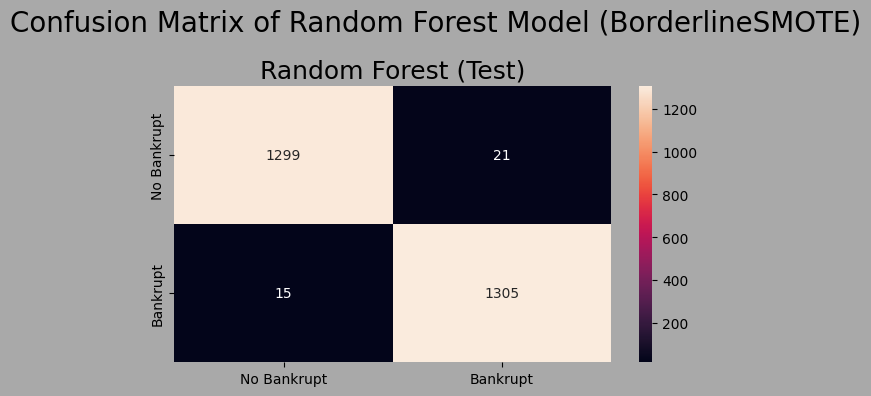

In [38]:
cm_rf_test = confusion_matrix(y_test, rf_test_preds, labels=random_forest.classes_)

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1 = sns.heatmap(cm_rf_test, annot=True, fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.set_title('Random Forest (Test)', fontsize=18)

fig.suptitle("Confusion Matrix of Random Forest Model (BorderlineSMOTE)", fontsize=20) 

plt.tight_layout()
fig.set_facecolor('darkgrey')
plt.show()

### 5.2. K Nearest Neighbours

- train data의 모형을 적합시키고, train data의 점수를 계산

In [39]:
KNN = KNeighborsClassifier(n_neighbors=2)

KNN.fit(X_train,y_train)

# Use the model to predict on train data
KNN_train_preds = KNN.predict(X_train)

KNN_train_results2 = get_test_scores('KNN (train, borderlinesmote, -outlier)',KNN_train_preds,y_train)
KNN_train_results2

,model,precision,recall,F1,accuracy
0,"KNN (train, borderlinesmote, -outlier)",0.99171,0.99157,0.99157,0.99157


- 그런 다음 test data의 점수를 계산

In [40]:
# Use the model to predict on test data
KNN_test_preds = KNN.predict(X_test)

KNN_test_results2 = get_test_scores('KNN (test, borderlinesmote, -outlier)',KNN_test_preds,y_test)
KNN_test_results2

,model,precision,recall,F1,accuracy
0,"KNN (test, borderlinesmote, -outlier)",0.958094,0.957955,0.957951,0.957955


- confusion matrix

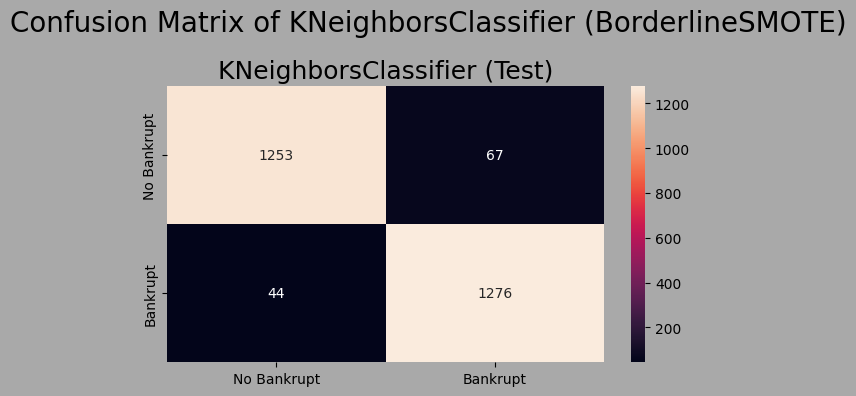

In [41]:
cm_KNN_test = confusion_matrix(y_test, KNN_test_preds, labels=KNN.classes_)

 
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1 = sns.heatmap(cm_KNN_test, annot=True, fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.set_title('KNeighborsClassifier (Test)', fontsize=18)

fig.suptitle("Confusion Matrix of KNeighborsClassifier (BorderlineSMOTE)", fontsize=20) 

plt.tight_layout()
fig.set_facecolor('darkgrey')
plt.show()

### 5.3 XGBoost

- train data의 모형을 적합시키고, train data의 점수를 계산

In [42]:
xgb = XGBClassifier(objective='binary:logistic',random_state=42)

xgb.fit(X_train,y_train)

# Use the model to predict on train data
xgb_train_preds = xgb.predict(X_train)

xgb_train_results2 = get_test_scores('XGB (train, borderlinesmote, -outlier)',xgb_train_preds,y_train)
xgb_train_results2

,model,precision,recall,F1,accuracy
0,"XGB (train, borderlinesmote, -outlier)",1.0,1.0,1.0,1.0


- 그런 다음 test data의 점수를 계산

In [43]:
# Use the model to predict on test data
xgb_test_preds = xgb.predict(X_test)

xgb_test_results2 = get_test_scores('XGB (test, borderlinesmote, -outlier)',xgb_test_preds,y_test)
xgb_test_results2  

,model,precision,recall,F1,accuracy
0,"XGB (test, borderlinesmote, -outlier)",0.988265,0.988258,0.988258,0.988258


- confusion matrix

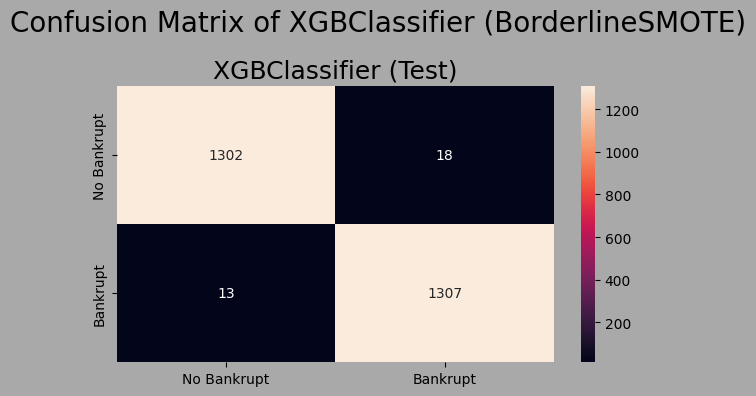

In [44]:
cm_xgb_test = confusion_matrix(y_test, xgb_test_preds, labels=xgb.classes_)

 
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1 = sns.heatmap(cm_xgb_test, annot=True, fmt='.4g')
ax1.xaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.yaxis.set_ticklabels(['No Bankrupt', 'Bankrupt']) 
ax1.set_title('XGBClassifier (Test)', fontsize=18)

fig.suptitle("Confusion Matrix of XGBClassifier (BorderlineSMOTE)", fontsize=20) 

plt.tight_layout()
fig.set_facecolor('darkgrey')
plt.show()

### 5.4 LogisticRegression

In [45]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=42)

LR.fit(X_train,y_train)

# Use the model to predict on train data
LR_train_preds = LR.predict(X_train)

LR_train_results2 = get_test_scores('LR (train, borderlinesmote, -outlier)',LR_train_preds,y_train)
LR_train_results2

,model,precision,recall,F1,accuracy
0,"LR (train, borderlinesmote, -outlier)",0.567015,0.55986,0.547788,0.55986


In [46]:
# Use the model to predict on test data
LR_test_preds = LR.predict(X_test)

LR_test_results2 = get_test_scores('LR (test, borderlinesmote, -outlier)',LR_test_preds,y_test)
LR_test_results2

,model,precision,recall,F1,accuracy
0,"LR (test, borderlinesmote, -outlier)",0.565691,0.557955,0.544544,0.557955


In [47]:
results2 = pd.concat([rf_test_results2,KNN_test_results2,xgb_test_results2, LR_test_results2],axis=0)

results2.sort_values(by=['accuracy'],ascending=False)

,model,precision,recall,F1,accuracy
0,"XGB (test, borderlinesmote, -outlier)",0.988265,0.988258,0.988258,0.988258
0,"RF (test, borderlinesmote, -outlier)",0.986374,0.986364,0.986364,0.986364
0,"KNN (test, borderlinesmote, -outlier)",0.958094,0.957955,0.957951,0.957955
0,"LR (test, borderlinesmote, -outlier)",0.565691,0.557955,0.544544,0.557955


In [48]:
results.sort_values(by=['accuracy'],ascending=False)

,model,precision,recall,F1,accuracy
0,"XGB (test, borderlinesmote)",0.986108,0.985985,0.985984,0.985985
0,"RF (test, borderlinesmote)",0.983404,0.983333,0.983333,0.983333
0,"KNN (test, borderlinesmote)",0.962590,0.962121,0.962112,0.962121
0,"LR (test, borderlinesmote)",0.687641,0.683333,0.681505,0.683333
